# **Chapter 20**  
**┗ 차년도 발주를 위한 발주수량 예측**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「발주 추이 분석」
* 🥈Session 2 - 「시계열 분해」
* 🥇Session 3 - 「Arima 활용 시계열 예측」

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter20')
# '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter20' ← 변경X
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter20'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🎫 (재고관리자)

```
A사는 매 년 차년도 발주 계획을 세우고 선발주를 통해 재고를 관리한다. 선주문을 진행하기 때문에 수요예측이 매우 중요한 역할을 한다.  
과도하게 주문할 시 창고 비용이 증가할 것이고, 적게 예측시 생산 스케줄에 대응하지 못하게 된다. 따라서 과거 발주 데이터를 활용하여  
수요예측 모델을 만들고 발주 계획에 활용하고자 한다.

```  

> **데이터 살펴보기**

* 재고발주 데이터
* M3 : 자재 발주량

In [2]:
# ▶ Data read
import pandas as pd
df = pd.read_excel("chapter20_order.xlsx")
df = pd.DataFrame(df)
df.head(10)

,Date,M3
0,2012-01-01,27
1,2012-02-01,37
2,2012-03-01,8
3,2012-04-01,9
4,2012-05-01,11
5,2012-06-01,7
6,2012-07-01,5
7,2012-08-01,8
8,2012-09-01,23
9,2012-10-01,4



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 선발주로 인한 창고비용 증가, 생산 스케줄 대응 장애
```  

> **기대효과**

```
▶ 창고비용 절감, 생산 스케줄 유연하게 대응
```

> **해결방안**

```
▶ 수요예측 모델 활용 재고관리
▶ Session 1 🥉
 - Data 전처리 및 발주 추이(Trend) 분석 
▶ Session 2 🥈
 - 시계열 데이터 분해 이해
▶ Session 3 🥇
 - Sesonal Arima 모델 활용 자재발주량 예측 수행 및 평가
```

> **성과측정**  

```
▶ 재고관리를 통한 감소 비용 측정
```

> **현업적용**  

```
▶ 모델링을 통해 선발주 수량 예측 및 활용
```

> **주요 코드 미리 살펴보기**  

```
▶ session 1 → plt.plot
▶ session 2 → seasonal_decompose
▶ session 3 → itertools, sm.tsa.statespace.SARIMAX()
```

## **🥉Session 1**  
**┗ 발주 추이 분석**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인 

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  


In [4]:
# ▶ Data 형태 확인
# ▶ 82 row, 2 col로 구성됨
print('df', df.shape)

df (82, 2)


In [5]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    82 non-null     datetime64[ns]
 1   M3      82 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 KB


In [6]:
# ▶ Null 값 확인
print(df.isnull().sum())

Date    0
M3      0
dtype: int64


In [7]:
# ▶ Outlier 확인
df.describe()

,M3
count,82.000000
mean,82.134146
std,79.807138
min,2.000000
25%,26.250000
50%,53.500000
75%,131.000000
max,393.000000


### · 발주 추이 분석
---

In [8]:
df.head(5)

,Date,M3
0,2012-01-01,27
1,2012-02-01,37
2,2012-03-01,8
3,2012-04-01,9
4,2012-05-01,11


In [9]:
df['Date'].min(), df['Date'].max() 

(Timestamp('2012-01-01 00:00:00'), Timestamp('2018-10-01 00:00:00'))

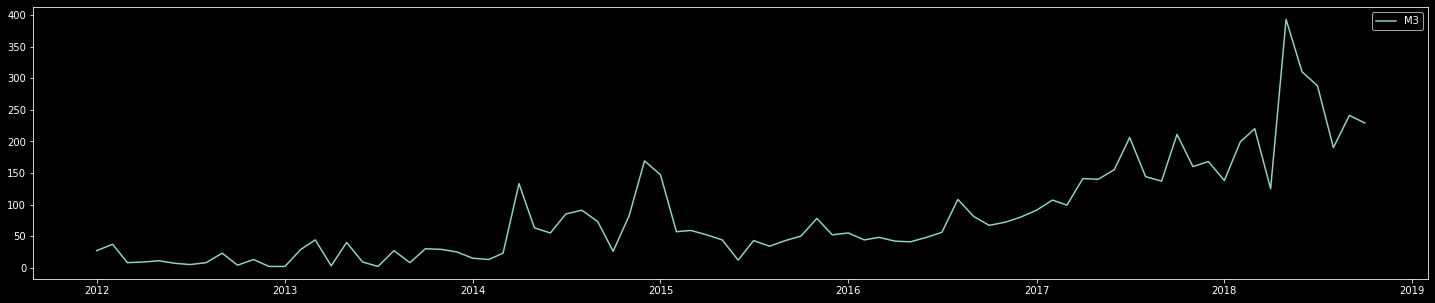

In [10]:
# ▶ 전체 기간 Plotting 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

plt.plot(df['Date'], df['M3'], label='M3');
plt.legend();
plt.gcf().set_size_inches(25, 5)

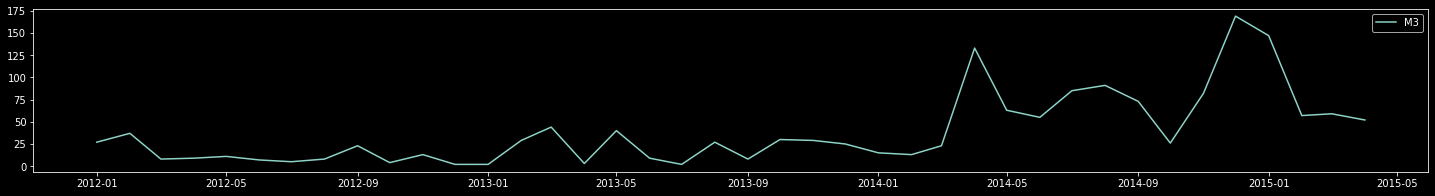

In [11]:
# ▶ 일부 기간 Plotting [0:40]
plt.plot(df['Date'][0:40], df['M3'][0:40], label='M3');
plt.legend();
plt.gcf().set_size_inches(25, 3)

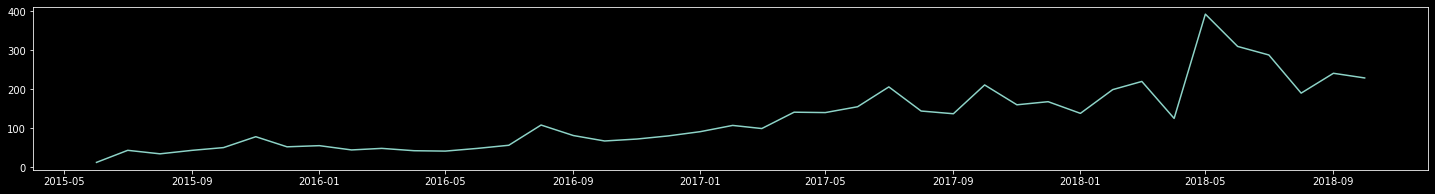

In [12]:
# ▶ 일부 기간 Plotting [41:]
plt.plot(df['Date'][41:], df['M3'][41:], label='M3');
plt.gcf().set_size_inches(25, 3)

In [13]:
df.head(5)

,Date,M3
0,2012-01-01,27
1,2012-02-01,37
2,2012-03-01,8
3,2012-04-01,9
4,2012-05-01,11


In [14]:
# ▶ 월 별 비교
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df.head(5)

,Date,M3,year,month
0,2012-01-01,27,2012,1
1,2012-02-01,37,2012,2
2,2012-03-01,8,2012,3
3,2012-04-01,9,2012,4
4,2012-05-01,11,2012,5


In [15]:
# ▶ pivot table을 활용 년도벼 월별 자재 발주량 비교
df_pivot = pd.pivot_table(df,                  # 피벗할 데이터프레임
                      index = 'year',          # 행 위치에 들어갈 열
                      columns = 'month',       # 열 위치에 들어갈 열
                      values = 'M3')           # 데이터로 사용할 열 

df_pivot

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2012,27.0,37.0,8.0,9.0,11.0,7.0,5.0,8.0,23.0,4.0,13.0,2.0
2013,2.0,29.0,44.0,3.0,40.0,9.0,2.0,27.0,8.0,30.0,29.0,25.0
2014,15.0,13.0,23.0,133.0,63.0,55.0,85.0,91.0,73.0,26.0,82.0,169.0
2015,147.0,57.0,59.0,52.0,44.0,12.0,43.0,34.0,43.0,50.0,78.0,52.0
2016,55.0,44.0,48.0,42.0,41.0,48.0,56.0,108.0,81.0,67.0,72.0,80.0
2017,91.0,107.0,99.0,141.0,140.0,155.0,206.0,144.0,137.0,211.0,160.0,168.0
2018,138.0,199.0,220.0,125.0,393.0,310.0,288.0,190.0,241.0,229.0,NaN,NaN


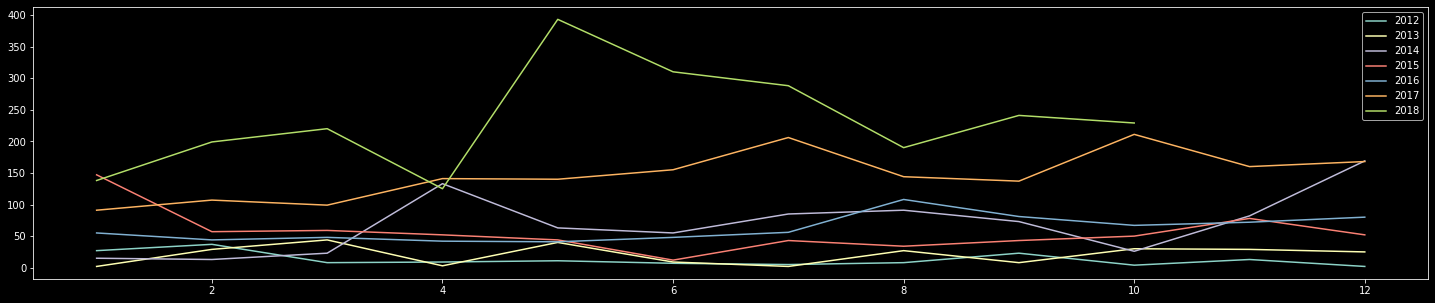

In [16]:
plt.plot(df_pivot.iloc[0,:], label='2012');
plt.plot(df_pivot.iloc[1,:], label='2013');
plt.plot(df_pivot.iloc[2,:], label='2014');
plt.plot(df_pivot.iloc[3,:], label='2015');
plt.plot(df_pivot.iloc[4,:], label='2016');
plt.plot(df_pivot.iloc[5,:], label='2017');
plt.plot(df_pivot.iloc[6,:], label='2018');
plt.legend();
plt.gcf().set_size_inches(25, 5)

## **🥈Session 2**  
**┗ 시계열 분해**  
---

### · 시계열 분해 
---

목적 : 시계열 데이터를 상세하게 이해하기 위한 전통적인 방법

* Trend (추세) : 시간에 따라 변화하는 Trend
* Seasonality (계절성) : 반복되는 Trend
* Residual (잔차) : 그 밖에 불규칙한 패턴
  
  

※ 고전적인 분해의 한계점
* 추세-주기 측정은 데이터에 나타나는 급격한 기울기 변화에 대해 불리
* 계절성이 지속적으로 반복한다는 가정에 기반하기 때문에 계절성 변화에 대해 불리
* **특이상황을 다루지 못한다.**  
→ X11 분해, SEATS 분해, STL 분해 등 

---


* 덧셈 분해 (additive decomposition)  
 - y = S + T + R
```
 Trend가 일정함에 따라 변동폭이 동일하면 덧셈 분해(additive decomposition) 
 (※ Trend와 Seasonal의 관계가 없다.)
```




* 곱셈 분해 (multiplicative decomposition)  
 - y = S x T x R
```
  Trend가 상승함에 따라 변동폭이 변화하면 곱셈 분해(multiplicative decomposition)    
 (※ Trend변화에 따라 Seasonal의 관계가 있다.)
```





In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    82 non-null     datetime64[ns]
 1   M3      82 non-null     int64         
 2   year    82 non-null     int64         
 3   month   82 non-null     int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 2.7 KB


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Date,M3,year,month
0,2012-01-01,27,2012,1
1,2012-02-01,37,2012,2
2,2012-03-01,8,2012,3
3,2012-04-01,9,2012,4
4,2012-05-01,11,2012,5


In [ ]:
df=df.set_index('Date')
df.head(5)

,M3,year,month
Date,,,
2012-01-01,27,2012,1
2012-02-01,37,2012,2
2012-03-01,8,2012,3
2012-04-01,9,2012,4
2012-05-01,11,2012,5


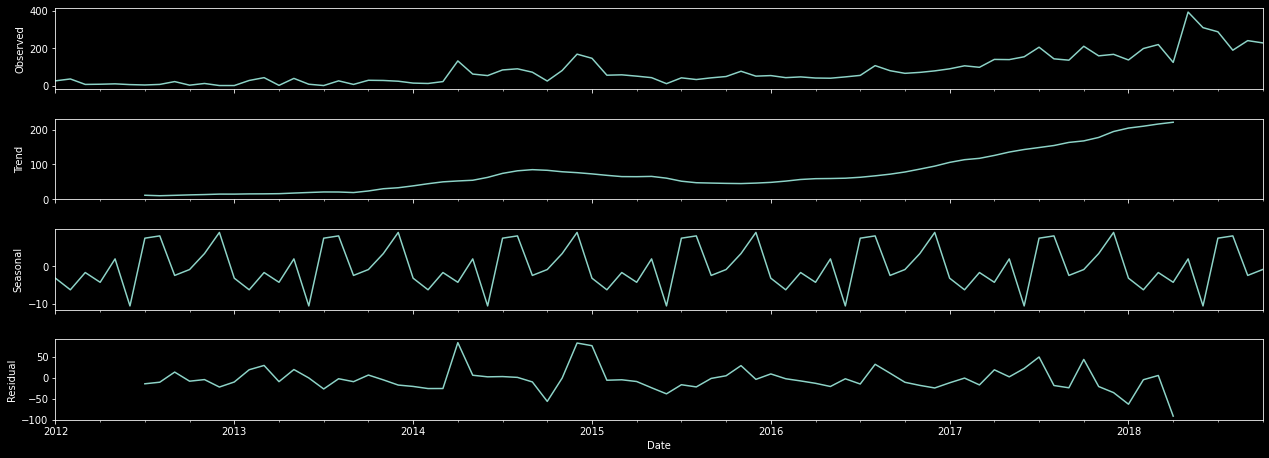

In [ ]:
# ▶ 덧셈 분해 (additive decomposition) 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df['M3'],model='addictive')
res.plot()
plt.gcf().set_size_inches(20, 7)
# plt.show()

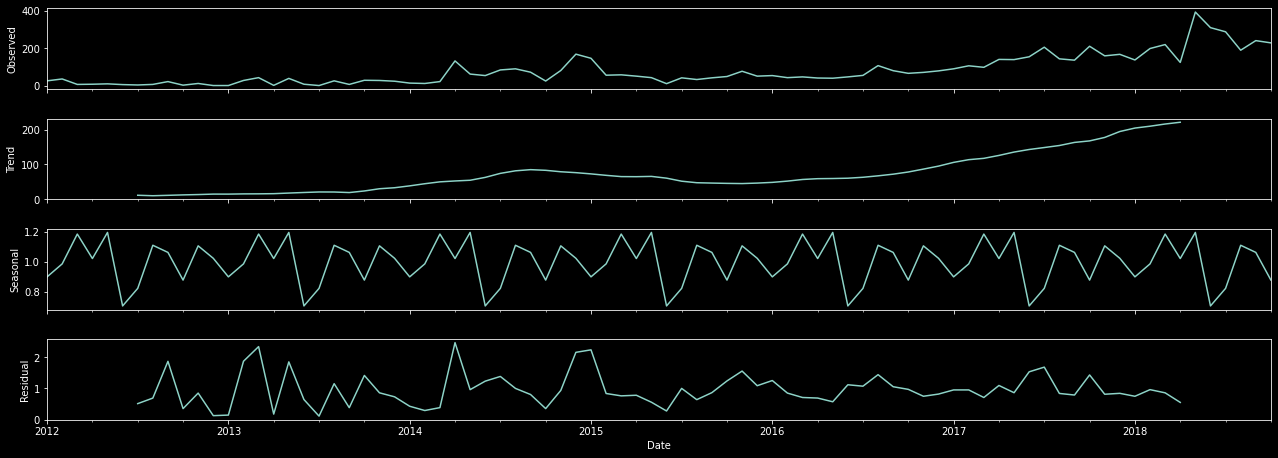

In [ ]:
# ▶ 곱셈 분해 (multiplicative decomposition)
# ▶ 잔차 그래프를 보면 덧셈 분해보다 더 민감하게 변화하는 패턴을 확인할 수 있음
res = seasonal_decompose(df['M3'],model='multiplicative')
res.plot()
plt.gcf().set_size_inches(20, 7)
#plt.show()

In [ ]:
# ▶ attribute 활용 실제 데이터 값 조회 가능
res.observed

Date
2012-01-01     27
2012-02-01     37
2012-03-01      8
2012-04-01      9
2012-05-01     11
             ... 
2018-06-01    310
2018-07-01    288
2018-08-01    190
2018-09-01    241
2018-10-01    229
Name: M3, Length: 82, dtype: int64

In [ ]:
# ▶ Trend를 표현하기 위해 앞, 뒤에 일부 데이터가 사라짐 (*약점)
res.trend

Date
2012-01-01   NaN
2012-02-01   NaN
2012-03-01   NaN
2012-04-01   NaN
2012-05-01   NaN
              ..
2018-06-01   NaN
2018-07-01   NaN
2018-08-01   NaN
2018-09-01   NaN
2018-10-01   NaN
Name: M3, Length: 82, dtype: float64

In [ ]:
# ▶ 중간값은 채워져 있음 
res.trend[30:40]

Date
2014-07-01    74.500000
2014-08-01    81.833333
2014-09-01    85.166667
2014-10-01    83.291667
2014-11-01    79.125000
2014-12-01    76.541667
2015-01-01    73.000000
2015-02-01    68.875000
2015-03-01    65.250000
2015-04-01    65.000000
Name: M3, dtype: float64

In [ ]:
# ▶ Seasonal 데이터 확인
res.seasonal

Date
2012-01-01    0.900295
2012-02-01    0.986397
2012-03-01    1.184340
2012-04-01    1.021823
2012-05-01    1.195039
                ...   
2018-06-01    0.707353
2018-07-01    0.823849
2018-08-01    1.109924
2018-09-01    1.062558
2018-10-01    0.878859
Name: M3, Length: 82, dtype: float64

In [ ]:
# ▶ 잔차 데이터 확인
res.resid

Date
2012-01-01   NaN
2012-02-01   NaN
2012-03-01   NaN
2012-04-01   NaN
2012-05-01   NaN
              ..
2018-06-01   NaN
2018-07-01   NaN
2018-08-01   NaN
2018-09-01   NaN
2018-10-01   NaN
Name: M3, Length: 82, dtype: float64

## **🥇Session 3**  
**┗ Arima 활용 시계열 예측**  
---
* AR(Autoregression) + MA(Moving Average)

### · Hyper parameter 튜닝 
---


In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
import itertools
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq= [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
# ▶ 필요 없는 컬럼 사전 제거
df = df.drop(['year', 'month'], axis=1)
df.head(5)

,M3
Date,
2012-01-01,27
2012-02-01,37
2012-03-01,8
2012-04-01,9
2012-05-01,11


In [ ]:
# ▶ 모든 조합의 Parameter 모델 생성 후 AIC로 모델 성능 파악 (※ AIC가 작을수록 최적의 모델일 확률이 높다)
# ▶ 1년 단위 데이터이기 때문에 주기가 12
import statsmodels.api as sm
import numpy as np
np.random.seed(1234)
warnings.filterwarnings("ignore") # specify to ignore warning messages


cols = ['param','param_seasonal','aic']
lst = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            lst.append([param, param_seasonal, results.aic])
            df1 = pd.DataFrame(lst, columns=cols)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1000.3292122770475
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:831.2496601807422
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:789.7866810047587
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:664.4255818666273
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:792.2054815357807
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:771.4112962840671
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:675.0642816555652
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:666.4239232273669
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:929.4556694697258
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:782.934870001814
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:760.5470077862789
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:638.0698480454456
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:780.9654398905643
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:752.4203579971712
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:658.8043952235872
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:639.5737300620187
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:845.9343856515544
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:730.5310504703813
ARIMA(0, 1

In [ ]:
df1

,param,param_seasonal,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",1000.329212
1,"(0, 0, 0)","(0, 0, 1, 12)",831.249660
2,"(0, 0, 0)","(0, 1, 0, 12)",789.786681
3,"(0, 0, 0)","(0, 1, 1, 12)",664.425582
4,"(0, 0, 0)","(1, 0, 0, 12)",792.205482
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 12)",600.401288
60,"(1, 1, 1)","(1, 0, 0, 12)",717.133985
61,"(1, 1, 1)","(1, 0, 1, 12)",709.600925
62,"(1, 1, 1)","(1, 1, 0, 12)",614.539441


In [ ]:
# ▶ AIC가 최소가 되는 parameter 조합 
aic_min=df1['aic'].min()
optimal_para=df1.loc[df1['aic']==aic_min]
optimal_para

,param,param_seasonal,aic
27,"(0, 1, 1)","(0, 1, 1, 12)",599.147141


### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [ ]:
# ▶ Best score 기준 모델 학습
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(0,1,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6590      0.116     -5.692      0.000      -0.886      -0.432
ma.S.L12      -0.7417      0.367     -2.023      0.043      -1.460      -0.023
sigma2      2630.1017    310.260      8.477      0.000    2022.002    3238.201


In [ ]:
# ▶ Ljung-Box : 잔차가 White noise를 따르는지 (※ 시계열 모형이 잘 적합되었고 남은 잔차는 더이상 자기상관을 가지지 않는 백색 잡음)
# ▶ Jarque-Bera : 잔차의 분포가 normal distributison을 따르는지
# ▶ Hereroskeddasticity : 시간대별 잔차의 분산이 일정한지
# ▶ 모두 0.05 이상이므로 White noise를 따르며, normal distribution이며, 분산이 일정하다.
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                 M3   No. Observations:                   82
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -296.574
Date:                            Sun, 27 Mar 2022   AIC                            599.147
Time:                                    08:16:29   BIC                            605.169
Sample:                                01-01-2012   HQIC                           601.476
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6590      0.116     -5.692      0.000      -0.886      -0.432
ma.S.L12      -0.7417      0.367     -2.023      0.043      -1.460      -0.023
sigma2      2630.1017    310.260      8.477      0.000    2022.002    3238.201
===================================================================================
Ljung-Box (Q):                       18.70   Jarque-Bera (JB):                52.36
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.09   Skew:                             1.28
Prob(H) (two-sided):                  0.13   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

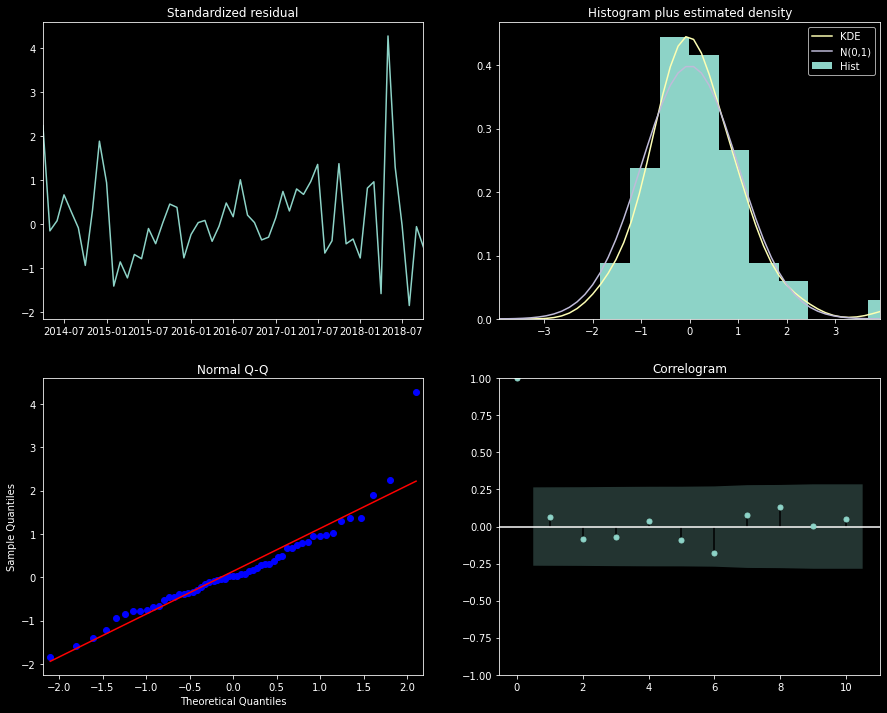

In [ ]:
# ▶ 생성된 모델 정합성 확인 과정 (※ Arima 모델을 사용할 수 있는지 판단하는 것, 잔차가 정상성을 따르는지)
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# ▶ (1) Standardized residual : 잔차가 백색잡음(White noise)에 가까울 수록 좋음, 평균 0을 중심으로 백색잡음의 형태 
# ▶ (2) Histogram plus estimated density : 잔차의 분포가 정규분포를 따르는지, 잔차의 히스토그램과 KDE plot을 그리고, N(0,1) 정규분포와 비교
# ▶ (3) Q-Q plot : 두개의 분포가 같은지 다른지 판단하는 Plot (x축 :이론적 샘플분포(정규분포), y축 : df['M3'])
# ▶ (4) Correlogram(콜렐로그램) : 잔차에대한 ACF, 예측된 자기상관성을 나타내기 위한 Plot, 초록색 Box 안에 들어와 있으면 자기상관성이 없다고 판단할 수 있음

# ▶ 약간의 정규성을 벗어난다, 예측 후 잘 맞지 않으면 파라미터 수정 후 재 진행

### · 예측 및 Plotting
---


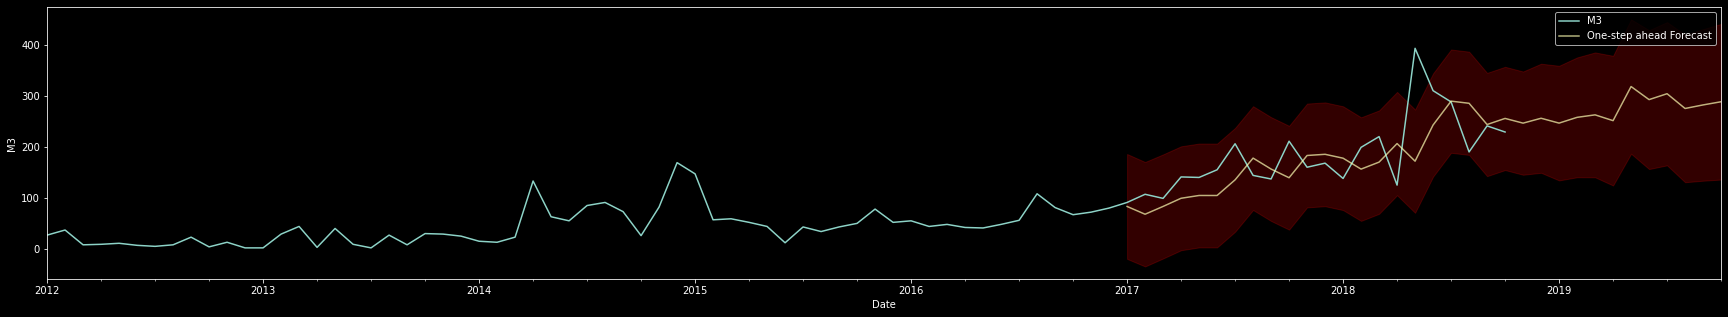

In [ ]:
#################################################################################################################
#--------------- start=pd.to_datetime(        ) ----------------------------------------------------------------#
#--------------- 예측을 시작 및 종료하고 싶은 날짜를 빈칸에 입력함 ---------------------------------------------#
#--------------- ex) 2017-01-01 --------------------------------------------------------------------------------#
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2019-10-01'), dynamic=False)
#################################################################################################################

pred_ci = pred.conf_int()
# 그래프를 2015년 부터 그리겠다.
ax = df['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('M3')
plt.legend()

plt.rcParams["figure.figsize"] = (30, 5)
plt.show()

In [ ]:
df.index.max()

Timestamp('2018-10-01 00:00:00')

In [ ]:
y_forecasted = pred.predicted_mean
########################################
# 위에서 선정한 예측 시작날짜를 입력   #
y_truth = df['2017-01-01':]
########################################

# Compute the mean square error
mse = ((y_forecasted - y_truth['M3']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

mae = (abs(y_forecasted - y_truth['M3'])).mean()
print('The MAE is {}'.format(round(mae, 2)))

The Mean Squared Error of our forecasts is 4345.03
The MAE is 47.93


In [ ]:
cols = ['y_truth','y_forecasted']
dat = []
result=pd.DataFrame(dat,columns=cols)
########################################
# 위에서 선정한 예측 시작날짜를 입력   #
y_real=df['2017-01-01':]
########################################

result['y_forecasted']=y_forecasted
result['y_truth']=y_real['M3']
result['diff'] = result['y_truth'] - result['y_forecasted']
result

,y_truth,y_forecasted,diff
2017-01-01,91.0,83.175757,7.824243
2017-02-01,107.0,67.938830,39.061170
2017-03-01,99.0,83.200814,15.799186
2017-04-01,141.0,99.200742,41.799258
2017-05-01,140.0,104.656336,35.343664
2017-06-01,155.0,104.631222,50.368778
2017-07-01,206.0,135.285839,70.714161
2017-08-01,144.0,177.907443,-33.907443
2017-09-01,137.0,156.424170,-19.424170
2017-10-01,211.0,139.425423,71.574577
